# Unet for MSRC-v2 segmentation dataset

姓名：盘国萍$\quad\quad$  学号：19040100128

该文件主要使用Unet来完成MSCV-v2数据的语义分割任务

## import modules

In [30]:
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import glob
import cv2
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import time
import pandas
import os

## Color Map for Visualization

In [31]:
color_map=[[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],
[0, 0, 128],[0, 128, 128],[128, 128, 128],[192, 0, 0],
[64, 128, 0],[192, 128, 0],[64, 0, 128],[192, 0, 128],
[64, 128, 128],[192, 128, 128],[0, 64, 0],[128, 64, 0],
[0, 192, 0],[128, 64, 128],[0, 192, 128],[128, 192, 128],
[64, 64, 0],[192, 64, 0]]

## Data Processing

### UnetDataset

In [32]:
class UnetDatset(Dataset):
    def __init__(self,img_dir,anotiaiton_file,gt_dir,num_classes=22,transform=None,target_transform=None):
        super(UnetDatset, self).__init__()
        
        self.img_dir = img_dir
        self.img_path = pandas.read_csv(anotiaiton_file).values.squeeze().tolist()
        self.gt_dir = gt_dir
        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, item):
        # X = cv2.imread(self.img_path[item])[:,:,[2,1,0]]
        # y = cv2.imread(self.gt_path[item])[:,:,[2,1,0]]
        
        X = Image.open(self.img_dir+self.img_path[item]).convert('RGB')
        y = Image.open(self.gt_dir+self.img_path[item][:-4]+'_GT.bmp').convert('L')
        label = None
        assert(X is not None and y is not None)
        
        if self.transform is not None:
            X = self.transform(X)

        if self.target_transform is not None:
            y = self.target_transform(y)
        
        temp = np.array(y)
        label =  np.array([1*(temp==i) for i in range(self.num_classes)])
        label = torch.from_numpy(label).permute(1,2,0)
        
            
        return X,y,label

### Transform

In [33]:
class Resize(object):
    '''
        @param[in]: size,用于缩放图像
        @param[in]: isTarget,是否是目标图像(label)
    
    Tips:
        使用等宽高比例放缩，并对不符合尺寸的图像进行填充
        
        对于输入图像(RGB)使用双线性插值来进行缩放
        对于目标图像(L)使用最近邻插值来进行缩放
    
    '''
    def __init__(self,size,isTarget=False):
        if isinstance(size,tuple):
            self.output_size = size
        else:
            self.output_size = (size,size)

        self.isTarget = isTarget

    def __call__(self,sample):
        
        w,h = self.output_size
        iw,ih = sample.size
        scale = min(h/ih,w/iw)
        nw,nh = int(iw * scale),int(ih * scale)

        if self.isTarget:
            sample = sample.resize((nw, nh), Image.NEAREST)
            new_sample= Image.new('L', [w, h], 0)
            new_sample.paste(sample, ((w - nw) // 2, (h - nh) // 2))

        else:
            sample = sample.resize((nw, nh), Image.BICUBIC)
            new_sample = Image.new('RGB', [w, h], (128, 128, 128))
            new_sample.paste(sample, ((w - nw) // 2, (h - nh) // 2))

        return new_sample
    
class ToTensor(object):
    '''
    Tips:
        对于目标图像通道默认为1，因此即不考虑%killbgscripts道数
    
    '''
    def __init__(self,isTarget=False):
        self.isTarget = isTarget

    def __call__(self,sample):


        if self.isTarget:
            sample = torch.from_numpy(np.array(sample)).long()


        else:
            sample = torch.from_numpy(np.array(sample)).float()/255.0
            sample = sample.permute(2, 0, 1)

        return sample


In [34]:
transform = transforms.Compose([
    Resize((320,320)),
    ToTensor()
])

target_transform = transforms.Compose([
    Resize((320,320),True),
    ToTensor(isTarget=True)
])

## Build Model

### Unet的主干示意图(其中图片和特征图的尺寸根据自己的需要进行调整)

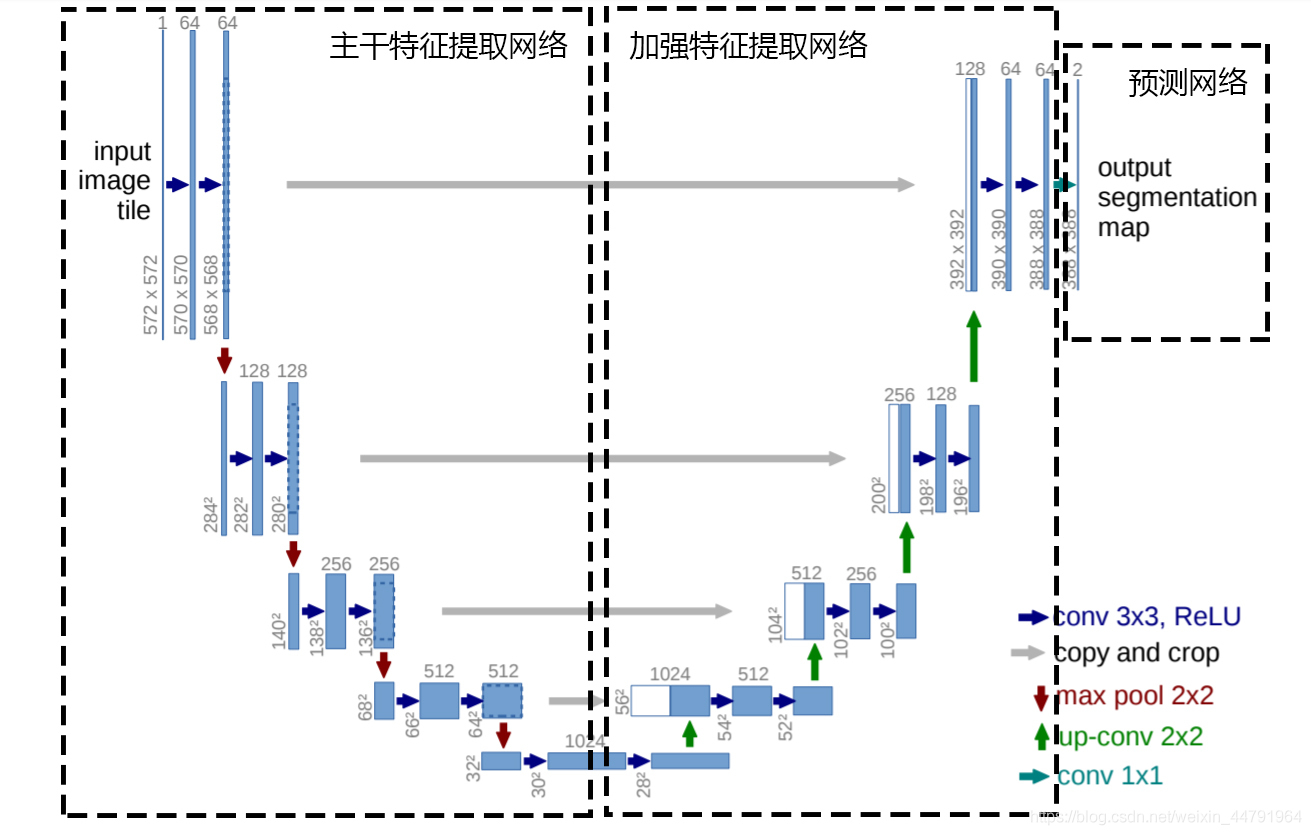

### 设计思路

- 通过观察发现主干特征提取网络使用Conv+Pooling的结构，因此考虑使用VGG16来作为特征提取网络
- VGG16可以加载pretrain-model，进一步提升分割精度
- 使用双线性插值的方法完成UpSampling，保存特征的空间信息，而不是使用Deconvolution

资料：
- [UpSampling](https://www.cnblogs.com/wanghui-garcia/p/11399053.html)
- [Deconvolution](https://www.freesion.com/article/5924530862/)
- UnPooling

### UpSampling+Concatenate

In [35]:
class UpCat(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(UpCat, self).__init__()
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1)

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,lowpixel,uppixel):
        output = torch.cat([self.upsample(lowpixel),uppixel],dim=1)
        output = self.relu(self.conv1(output))
        output = self.relu(self.conv2(output))

        return output

### Unet

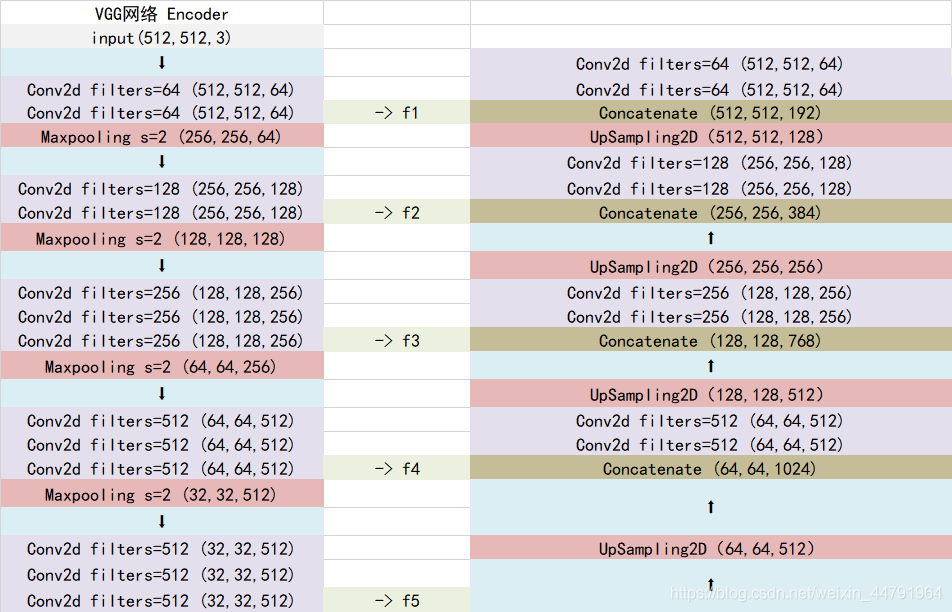

In [36]:
class Unet(nn.Module):
    '''
        Feature_Extractor:
           
           512*512*3 ->  512*512*64(feature1)
            -> 256*256*64 -> 256*256*128(feature2)
            -> 128*128*128 -> 128*128*256(feature3)
            -> 64*64*256 -> 64*64*512(feature4)
            -> 32*32*512 -> 32*32*512(feature5)

        UpSampling:
            
            说明：可以看到UpSampling是从最后一层开始往上进行的，
                  如第五层的特征尺度(32*32)要和第四层特征(64*64)进行融合的时候，
                  需要对第五层特征进行UpSamping成(64*64)再进行融合
            
            32*32*512(feature5) -> 64*64*512(feature5+up)
            64*64*512(feature5+up) + 64*64*512(feature4) = 64*64*1024(upcat1)

            64*64*1024(upcat1) -> 128*128*512(upcat1+up)
            128*128*512(upcat1+up) + 128*128*256(feature3) = 128*128*768(upcat2)

            128*128*768(upcat2) -> 256*256*256(upcat2+up)
            256*256*256(upcat2+up) + 256*256*128(feature2) = 256*256*384(upcat3)

            256*256*384(upcat3) -> 512*512*128(upcat3+up)
            512*512*128(upcat3+up) + 512*512*64(feature1) = 512*512*192(upcat4)

            512*512*192(upcat4) -> 512*512*64
        
        Segmentation:
        
            512*512*64 -> 512*512*num_classes(output)
            
    '''
    def __init__(self,num_classes = 22,in_channels = 3,backbond='vgg16',pretrain=True):
        super(Unet, self).__init__()
        self.vgg = getattr(models,backbond)()
        self.vgg.load_state_dict(torch.load('model/vgg16-397923af.pth'))
        del self.vgg.avgpool
        del self.vgg.classifier

        concat_channels = [1024,768,384,192]
        out_channels = [512,256,128,64]

        self.upcat1 = UpCat(concat_channels[0],out_channels[0])
        self.upcat2 = UpCat(concat_channels[1],out_channels[1])
        self.upcat3 = UpCat(concat_channels[2],out_channels[2])
        self.upcat4 = UpCat(concat_channels[3],out_channels[3])


        self.segmentors = nn.Conv2d(out_channels[-1],num_classes,kernel_size=1)

    def forward(self,x):
        feature1 = self.vgg.features[:4](x) # 2 conv 512
        feature2 = self.vgg.features[4:9](feature1) # pooling + 2 conv 256
        feature3 = self.vgg.features[9:16](feature2) # pooling + 3 conv 128
        feature4 = self.vgg.features[16:23](feature3) # pooling + 3 conv 64
        feature5 = self.vgg.features[23:-1](feature4) # pooling + 3 conv 32

        up1 = self.upcat1(feature5,feature4) # 64
        up2 = self.upcat2(up1,feature3) # 128
        up3 = self.upcat3(up2,feature2) # 256
        up4 = self.upcat4(up3,feature1) # 512

        output = self.segmentors(up4)

        return output

## Loss

### Dice Loss

定义：
$$DiceCoefficient= \frac{2∣X⋂Y∣}{∣X∣+∣Y∣}$$

$$DiceLoss = 1-DiceCoefficient$$

> Tips:这里为了方便运算，与处理异常，对公式进行了如下修改

<div align="center"><img src="IOU.png" width="400" ></div>

$$DiceCoefficient= \frac{2*tp}{2*tp+fn+fp}$$

加入$beta$、$smooth$后：

$$DiceCoefficient= \frac{(1+beta^2)*tp+smooth}{(1+beta^2)*tp+beta^2 * fn + fp +smooth}$$

资料：
- https://blog.csdn.net/qq_34107425/article/details/110119894

In [37]:
def Dice_Loss(inputs,target,beta=1,smooth=1e-5):
    n, c, h, w = inputs.size()
    nt,ht, wt,ct = target.size()
    
#     if h != ht and w != wt:
#         inputs = torch.nn.functional.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = torch.softmax(inputs.permute(0,2,3,1).contiguous().view(n, -1, c), -1)
    temp_target = target.view(n, -1,ct)
    
    tp = torch.sum(temp_target*temp_inputs, axis=[0, 1])
    fp = torch.sum(temp_inputs,axis=[0,1]) - tp
    fn = torch.sum(temp_target,axis=[0,1]) - tp

    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    dice_loss = 1 - torch.mean(score)
    return dice_loss

### CrossEntropyLoss

In [38]:
def CE_Loss(inputs, target):
    n, c, h, w = inputs.size()
    nt,ht, wt = target.size()
    if h != ht and w != wt:
        inputs = torch.nn.functional.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    CE_loss  = nn.CrossEntropyLoss()(inputs, target)
    return CE_loss

### mIOU

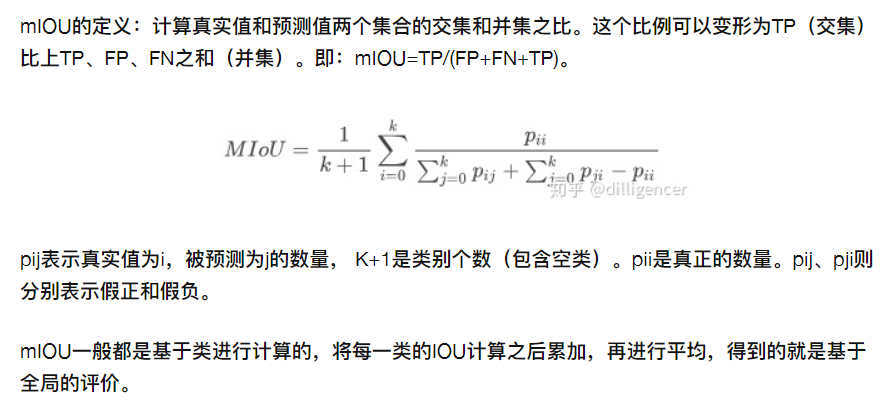

资料：
- https://zhuanlan.zhihu.com/p/88805121

In [39]:
def mIoU(inputs,target,smooth = 1e-5):
    n, c, h, w = inputs.size()
    nt, ht, wt, ct = target.size()
#     if h != ht and w != wt:
#         inputs = torch.nn.functional.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = torch.softmax(inputs.permute(0,2,3,1).contiguous().view(n, -1, c), -1)
    temp_target = target.view(nt, -1,ct)
    
    tp = torch.sum(temp_target*temp_inputs, axis=[0, 1])
    fp = torch.sum(temp_inputs,axis=[0,1]) - tp
    fn = torch.sum(temp_target,axis=[0,1]) - tp


    score = (tp + smooth)/(tp + fn + fp + smooth)
    return torch.mean(score)

## Train

In [40]:
def train_model(model,train_loader,scheduler=None,num_epochs = 2):
    best_model_dict = copy.deepcopy(model.state_dict())
    best_score = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch:^5d}/{num_epochs-1:^5d}')
        print("----------------------------------------------")

        for state in ['train','val']:
            if state == 'train':
                model.train()
                if scheduler is not None:
                    scheduler.step()
            else:
                model.eval()

            score = 0.0
            total_loss = 0.0
            for i,(X,y,label) in enumerate(tqdm(train_loader[state])):
                time.sleep(0.01)
                X,y,label = X.to(device),y.to(device),label.to(device)

                optimizer.zero_grad()

                if hasattr(torch.cuda, 'empty_cache'):
                    torch.cuda.empty_cache()

                with torch.set_grad_enabled(state =='train'):
                    outputs = model(X)#[64,22,320,320]
                    loss = CE_Loss(outputs,y) + Dice_Loss(outputs,label)

                    if state == 'train':
                        loss.backward()
                        optimizer.step()

                score += mIoU(outputs,label)*X.shape[0]
#                 print(score)
                total_loss += loss*X.shape[0]

                if i%2 == 0:
                    print(f"Loss:{loss}")

            score /= len(train_loader[state])
            total_loss /= len(train_data[state])
            if state == 'val' and score > best_score:
                best_score  = score
                best_model_dict = copy.deepcopy(model.state_dict())
            print(f"{state} --- Loss:{total_loss} "
                  f"mIoU:{score}")

    return best_model_dict

### Load Data

In [41]:
img_dir = 'Dataset/msrc2_seg/images/'
gt_dir = 'Dataset/msrc2_seg/gt_label/'


In [42]:
train_file = 'Dataset/msrc2_seg/Train.txt'
val_file = 'Dataset/msrc2_seg/Validation.txt'
data_file = {'train':train_file,'val':val_file}
train_data = {x:UnetDatset(img_dir,data_file[x],gt_dir,transform=transform,target_transform=target_transform) for x in ['train','val']}


test_file = 'Dataset/msrc2_seg/Test.txt'
test_data = UnetDatset(img_dir,test_file,gt_dir,transform=transform,target_transform=target_transform)

In [43]:
batch_size = 1#这里显存不够,只能用小的batch_size了

In [44]:
train_loader = {x:DataLoader(train_data[x],batch_size,shuffle=True) for x in ['train','val']}
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### Create model

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [46]:
net = Unet().to(device)

In [130]:
epochs = 1
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.1)

Lr_Scheduler:

$$lr_{new} = lr_{old} * \gamma^{\frac{epoch}{step\_size}} $$

资料：

- https://zhuanlan.zhihu.com/p/380795956

In [122]:
best_model_dict = train_model(net,train_loader,lr_scheduler,epochs)

Epoch:   0  /  1  
----------------------------------------------


  0%|▎                                                                                 | 1/275 [00:03<16:17,  3.57s/it]

Loss:4.155636787414551


  1%|▉                                                                                 | 3/275 [00:12<19:55,  4.40s/it]

Loss:3.9440107345581055


  2%|█▍                                                                                | 5/275 [00:22<21:00,  4.67s/it]

Loss:3.9749820232391357


  3%|██                                                                                | 7/275 [00:32<21:10,  4.74s/it]

Loss:3.0245018005371094


  3%|██▋                                                                               | 9/275 [00:41<21:13,  4.79s/it]

Loss:3.066279888153076


  4%|███▏                                                                             | 11/275 [00:53<23:34,  5.36s/it]

Loss:3.3327555656433105


  5%|███▊                                                                             | 13/275 [01:03<22:46,  5.22s/it]

Loss:2.9224166870117188


  5%|████▍                                                                            | 15/275 [01:12<21:18,  4.92s/it]

Loss:3.323936700820923


  6%|█████                                                                            | 17/275 [01:21<19:28,  4.53s/it]

Loss:2.7637555599212646


  7%|█████▌                                                                           | 19/275 [01:29<18:27,  4.33s/it]

Loss:2.7420237064361572


  8%|██████▏                                                                          | 21/275 [01:37<18:00,  4.25s/it]

Loss:3.833988666534424


  8%|██████▊                                                                          | 23/275 [01:46<17:45,  4.23s/it]

Loss:2.389153480529785


  9%|███████▎                                                                         | 25/275 [01:55<18:10,  4.36s/it]

Loss:3.0132179260253906


 10%|███████▉                                                                         | 27/275 [02:04<18:17,  4.42s/it]

Loss:2.9484777450561523


 11%|████████▌                                                                        | 29/275 [02:12<17:48,  4.35s/it]

Loss:3.0987234115600586


 11%|█████████▏                                                                       | 31/275 [02:21<18:15,  4.49s/it]

Loss:2.311657190322876


 12%|█████████▋                                                                       | 33/275 [02:30<17:42,  4.39s/it]

Loss:2.7213048934936523


 13%|██████████▎                                                                      | 35/275 [02:38<17:07,  4.28s/it]

Loss:2.656064033508301


 13%|██████████▉                                                                      | 37/275 [02:47<16:47,  4.23s/it]

Loss:3.2431514263153076


 14%|███████████▍                                                                     | 39/275 [02:56<17:12,  4.38s/it]

Loss:2.9869959354400635


 15%|████████████                                                                     | 41/275 [03:04<16:57,  4.35s/it]

Loss:3.017548084259033


 16%|████████████▋                                                                    | 43/275 [03:13<16:34,  4.29s/it]

Loss:2.7331483364105225


 16%|█████████████▎                                                                   | 45/275 [03:21<16:23,  4.28s/it]

Loss:2.601577043533325


 17%|█████████████▊                                                                   | 47/275 [03:30<15:47,  4.16s/it]

Loss:2.541897773742676


 18%|██████████████▍                                                                  | 49/275 [03:38<15:54,  4.22s/it]

Loss:3.0709760189056396


 19%|███████████████                                                                  | 51/275 [03:47<16:07,  4.32s/it]

Loss:2.522321939468384


 19%|███████████████▌                                                                 | 53/275 [03:56<16:08,  4.36s/it]

Loss:2.411327362060547


 20%|████████████████▏                                                                | 55/275 [04:04<15:30,  4.23s/it]

Loss:2.0770578384399414


 21%|████████████████▊                                                                | 57/275 [04:12<15:07,  4.16s/it]

Loss:3.8800923824310303


 21%|█████████████████▍                                                               | 59/275 [04:21<14:55,  4.15s/it]

Loss:3.522810459136963


 22%|█████████████████▉                                                               | 61/275 [04:29<14:46,  4.14s/it]

Loss:2.6734142303466797


 23%|██████████████████▌                                                              | 63/275 [04:37<14:45,  4.18s/it]

Loss:3.6511645317077637


 24%|███████████████████▏                                                             | 65/275 [04:48<16:27,  4.70s/it]

Loss:1.9643443822860718


 24%|███████████████████▋                                                             | 67/275 [04:59<17:31,  5.05s/it]

Loss:2.882629156112671


 25%|████████████████████▎                                                            | 69/275 [05:07<15:55,  4.64s/it]

Loss:3.139847993850708


 26%|████████████████████▉                                                            | 71/275 [05:15<14:58,  4.40s/it]

Loss:3.131516456604004


 27%|█████████████████████▌                                                           | 73/275 [05:24<14:20,  4.26s/it]

Loss:3.1274540424346924


 27%|██████████████████████                                                           | 75/275 [05:32<13:57,  4.19s/it]

Loss:2.637810707092285


 28%|██████████████████████▋                                                          | 77/275 [05:42<15:02,  4.56s/it]

Loss:1.6784772872924805


 29%|███████████████████████▎                                                         | 79/275 [05:51<15:05,  4.62s/it]

Loss:2.470973014831543


 29%|███████████████████████▊                                                         | 81/275 [05:59<14:33,  4.50s/it]

Loss:2.6300551891326904


 30%|████████████████████████▍                                                        | 83/275 [06:08<13:59,  4.37s/it]

Loss:3.367795944213867


 31%|█████████████████████████                                                        | 85/275 [06:16<13:17,  4.20s/it]

Loss:1.913780927658081


 32%|█████████████████████████▋                                                       | 87/275 [06:24<13:13,  4.22s/it]

Loss:2.7630722522735596


 32%|██████████████████████████▏                                                      | 89/275 [06:34<13:53,  4.48s/it]

Loss:2.9104697704315186


 33%|██████████████████████████▊                                                      | 91/275 [06:43<13:35,  4.43s/it]

Loss:3.3571057319641113


 34%|███████████████████████████▍                                                     | 93/275 [06:51<13:02,  4.30s/it]

Loss:2.4570298194885254


 35%|███████████████████████████▉                                                     | 95/275 [07:00<12:58,  4.33s/it]

Loss:2.550809860229492


 35%|████████████████████████████▌                                                    | 97/275 [07:09<13:12,  4.45s/it]

Loss:2.6680147647857666


 36%|█████████████████████████████▏                                                   | 99/275 [07:18<12:59,  4.43s/it]

Loss:2.604006767272949


 37%|█████████████████████████████▍                                                  | 101/275 [07:27<13:03,  4.50s/it]

Loss:2.4967527389526367


 37%|█████████████████████████████▉                                                  | 103/275 [07:36<12:42,  4.43s/it]

Loss:2.364830732345581


 38%|██████████████████████████████▌                                                 | 105/275 [07:45<12:38,  4.46s/it]

Loss:2.727947235107422


 39%|███████████████████████████████▏                                                | 107/275 [07:53<12:21,  4.41s/it]

Loss:3.235452890396118


 40%|███████████████████████████████▋                                                | 109/275 [08:03<12:40,  4.58s/it]

Loss:2.688694715499878


 40%|████████████████████████████████▎                                               | 111/275 [08:11<12:10,  4.45s/it]

Loss:2.600098133087158


 41%|████████████████████████████████▊                                               | 113/275 [08:20<11:44,  4.35s/it]

Loss:1.9370388984680176


 42%|█████████████████████████████████▍                                              | 115/275 [08:29<11:33,  4.33s/it]

Loss:2.653660774230957


 43%|██████████████████████████████████                                              | 117/275 [08:38<11:55,  4.53s/it]

Loss:2.3516881465911865


 43%|██████████████████████████████████▌                                             | 119/275 [08:49<13:10,  5.07s/it]

Loss:2.7134761810302734


 44%|███████████████████████████████████▏                                            | 121/275 [08:59<12:31,  4.88s/it]

Loss:1.9959924221038818


 45%|███████████████████████████████████▊                                            | 123/275 [09:07<11:26,  4.52s/it]

Loss:1.6145069599151611


 45%|████████████████████████████████████▎                                           | 125/275 [09:16<10:57,  4.38s/it]

Loss:1.4201459884643555


 46%|████████████████████████████████████▉                                           | 127/275 [09:24<10:45,  4.36s/it]

Loss:2.6246376037597656


 47%|█████████████████████████████████████▌                                          | 129/275 [09:33<10:26,  4.29s/it]

Loss:1.94133460521698


 48%|██████████████████████████████████████                                          | 131/275 [09:41<10:23,  4.33s/it]

Loss:2.5518558025360107


 48%|██████████████████████████████████████▋                                         | 133/275 [09:50<10:01,  4.24s/it]

Loss:2.8259387016296387


 49%|███████████████████████████████████████▎                                        | 135/275 [09:58<09:47,  4.19s/it]

Loss:1.6888288259506226


 50%|███████████████████████████████████████▊                                        | 137/275 [10:07<09:58,  4.34s/it]

Loss:2.5848116874694824


 51%|████████████████████████████████████████▍                                       | 139/275 [10:15<09:41,  4.28s/it]

Loss:2.8496224880218506


 51%|█████████████████████████████████████████                                       | 141/275 [10:24<09:23,  4.20s/it]

Loss:2.6953556537628174


 52%|█████████████████████████████████████████▌                                      | 143/275 [10:33<09:30,  4.33s/it]

Loss:3.353799343109131


 53%|██████████████████████████████████████████▏                                     | 145/275 [10:41<09:22,  4.33s/it]

Loss:3.2635903358459473


 53%|██████████████████████████████████████████▊                                     | 147/275 [10:52<10:20,  4.85s/it]

Loss:2.8150148391723633


 54%|███████████████████████████████████████████▎                                    | 149/275 [11:01<10:11,  4.86s/it]

Loss:2.1059088706970215


 55%|███████████████████████████████████████████▉                                    | 151/275 [11:10<09:36,  4.65s/it]

Loss:2.4660937786102295


 56%|████████████████████████████████████████████▌                                   | 153/275 [11:19<08:55,  4.39s/it]

Loss:2.714642286300659


 56%|█████████████████████████████████████████████                                   | 155/275 [11:28<08:58,  4.49s/it]

Loss:2.625336170196533


 57%|█████████████████████████████████████████████▋                                  | 157/275 [11:36<08:37,  4.39s/it]

Loss:2.1557235717773438


 58%|██████████████████████████████████████████████▎                                 | 159/275 [11:45<08:35,  4.44s/it]

Loss:2.2449538707733154


 59%|██████████████████████████████████████████████▊                                 | 161/275 [11:54<08:35,  4.52s/it]

Loss:2.3180079460144043


 59%|███████████████████████████████████████████████▍                                | 163/275 [12:03<08:13,  4.41s/it]

Loss:2.7904934883117676


 60%|████████████████████████████████████████████████                                | 165/275 [12:12<08:07,  4.43s/it]

Loss:2.5310893058776855


 61%|████████████████████████████████████████████████▌                               | 167/275 [12:21<08:12,  4.56s/it]

Loss:2.217822551727295


 61%|█████████████████████████████████████████████████▏                              | 169/275 [12:31<08:05,  4.58s/it]

Loss:3.8091483116149902


 62%|█████████████████████████████████████████████████▋                              | 171/275 [12:39<07:34,  4.37s/it]

Loss:2.6636831760406494


 63%|██████████████████████████████████████████████████▎                             | 173/275 [12:47<07:25,  4.36s/it]

Loss:2.692136287689209


 64%|██████████████████████████████████████████████████▉                             | 175/275 [12:57<07:33,  4.53s/it]

Loss:3.026838779449463


 64%|███████████████████████████████████████████████████▍                            | 177/275 [13:06<07:17,  4.46s/it]

Loss:2.606802225112915


 65%|████████████████████████████████████████████████████                            | 179/275 [13:14<07:01,  4.39s/it]

Loss:2.7815892696380615


 66%|████████████████████████████████████████████████████▋                           | 181/275 [13:23<06:50,  4.37s/it]

Loss:2.597400665283203


 67%|█████████████████████████████████████████████████████▏                          | 183/275 [13:33<06:55,  4.52s/it]

Loss:2.598118543624878


 67%|█████████████████████████████████████████████████████▊                          | 185/275 [13:41<06:45,  4.50s/it]

Loss:2.215998649597168


 68%|██████████████████████████████████████████████████████▍                         | 187/275 [13:50<06:34,  4.49s/it]

Loss:2.433688163757324


 69%|██████████████████████████████████████████████████████▉                         | 189/275 [13:59<06:16,  4.37s/it]

Loss:1.9082704782485962


 69%|███████████████████████████████████████████████████████▌                        | 191/275 [14:09<06:34,  4.70s/it]

Loss:2.5496199131011963


 70%|████████████████████████████████████████████████████████▏                       | 193/275 [14:18<06:16,  4.59s/it]

Loss:3.3112294673919678


 71%|████████████████████████████████████████████████████████▋                       | 195/275 [14:28<06:31,  4.90s/it]

Loss:2.357473373413086


 72%|█████████████████████████████████████████████████████████▎                      | 197/275 [14:37<06:02,  4.65s/it]

Loss:2.492748737335205


 72%|█████████████████████████████████████████████████████████▉                      | 199/275 [14:46<05:43,  4.52s/it]

Loss:2.160142183303833


 73%|██████████████████████████████████████████████████████████▍                     | 201/275 [14:55<05:31,  4.48s/it]

Loss:2.2595784664154053


 74%|███████████████████████████████████████████████████████████                     | 203/275 [15:04<05:20,  4.45s/it]

Loss:2.3552143573760986


 75%|███████████████████████████████████████████████████████████▋                    | 205/275 [15:13<05:13,  4.48s/it]

Loss:2.5553019046783447


 75%|████████████████████████████████████████████████████████████▏                   | 207/275 [15:22<05:11,  4.58s/it]

Loss:1.5446395874023438


 76%|████████████████████████████████████████████████████████████▊                   | 209/275 [15:31<04:59,  4.54s/it]

Loss:2.750717878341675


 77%|█████████████████████████████████████████████████████████████▍                  | 211/275 [15:41<05:13,  4.90s/it]

Loss:2.3001291751861572


 77%|█████████████████████████████████████████████████████████████▉                  | 213/275 [15:51<04:59,  4.83s/it]

Loss:2.0332727432250977


 78%|██████████████████████████████████████████████████████████████▌                 | 215/275 [16:00<04:41,  4.70s/it]

Loss:2.1599862575531006


 79%|███████████████████████████████████████████████████████████████▏                | 217/275 [16:10<04:36,  4.77s/it]

Loss:2.177030324935913


 80%|███████████████████████████████████████████████████████████████▋                | 219/275 [16:19<04:26,  4.75s/it]

Loss:1.515448808670044


 80%|████████████████████████████████████████████████████████████████▎               | 221/275 [16:29<04:13,  4.70s/it]

Loss:2.8328967094421387


 81%|████████████████████████████████████████████████████████████████▊               | 223/275 [16:38<03:58,  4.59s/it]

Loss:2.8887319564819336


 82%|█████████████████████████████████████████████████████████████████▍              | 225/275 [16:47<03:47,  4.56s/it]

Loss:2.3161330223083496


 83%|██████████████████████████████████████████████████████████████████              | 227/275 [16:56<03:43,  4.65s/it]

Loss:2.6042165756225586


 83%|██████████████████████████████████████████████████████████████████▌             | 229/275 [17:05<03:32,  4.61s/it]

Loss:2.543147563934326


 84%|███████████████████████████████████████████████████████████████████▏            | 231/275 [17:14<03:20,  4.56s/it]

Loss:2.0969221591949463


 85%|███████████████████████████████████████████████████████████████████▊            | 233/275 [17:24<03:15,  4.66s/it]

Loss:1.8562183380126953


 85%|████████████████████████████████████████████████████████████████████▎           | 235/275 [17:34<03:18,  4.95s/it]

Loss:2.2891178131103516


 86%|████████████████████████████████████████████████████████████████████▉           | 237/275 [17:44<03:10,  5.01s/it]

Loss:2.0763418674468994


 87%|█████████████████████████████████████████████████████████████████████▌          | 239/275 [17:53<02:48,  4.69s/it]

Loss:2.8474645614624023


 88%|██████████████████████████████████████████████████████████████████████          | 241/275 [18:02<02:37,  4.64s/it]

Loss:1.9861743450164795


 88%|██████████████████████████████████████████████████████████████████████▋         | 243/275 [18:12<02:31,  4.73s/it]

Loss:2.374661922454834


 89%|███████████████████████████████████████████████████████████████████████▎        | 245/275 [18:23<02:35,  5.18s/it]

Loss:2.347533702850342


 90%|███████████████████████████████████████████████████████████████████████▊        | 247/275 [18:38<02:59,  6.40s/it]

Loss:2.262641668319702


 91%|████████████████████████████████████████████████████████████████████████▍       | 249/275 [18:50<02:41,  6.20s/it]

Loss:6.017873764038086


 91%|█████████████████████████████████████████████████████████████████████████       | 251/275 [19:02<02:28,  6.18s/it]

Loss:2.714606285095215


 92%|█████████████████████████████████████████████████████████████████████████▌      | 253/275 [19:13<02:08,  5.82s/it]

Loss:2.421044111251831


 93%|██████████████████████████████████████████████████████████████████████████▏     | 255/275 [19:22<01:40,  5.03s/it]

Loss:2.2019927501678467


 93%|██████████████████████████████████████████████████████████████████████████▊     | 257/275 [19:31<01:24,  4.72s/it]

Loss:1.9342416524887085


 94%|███████████████████████████████████████████████████████████████████████████▎    | 259/275 [19:39<01:11,  4.47s/it]

Loss:1.4982542991638184


 95%|███████████████████████████████████████████████████████████████████████████▉    | 261/275 [19:48<01:02,  4.48s/it]

Loss:3.589242458343506


 96%|████████████████████████████████████████████████████████████████████████████▌   | 263/275 [19:56<00:51,  4.33s/it]

Loss:2.2641613483428955


 96%|█████████████████████████████████████████████████████████████████████████████   | 265/275 [20:05<00:42,  4.22s/it]

Loss:2.9543981552124023


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 267/275 [20:14<00:35,  4.40s/it]

Loss:2.619009494781494


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 269/275 [20:23<00:26,  4.41s/it]

Loss:2.4886629581451416


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 271/275 [20:32<00:17,  4.40s/it]

Loss:2.4425771236419678


 99%|███████████████████████████████████████████████████████████████████████████████▍| 273/275 [20:40<00:08,  4.41s/it]

Loss:2.5026438236236572


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [20:49<00:00,  4.54s/it]

Loss:2.0684282779693604
train --- Loss:2.6279489994049072 mIoU:0.03343873843550682



  2%|█▍                                                                                 | 1/58 [00:01<01:29,  1.57s/it]

Loss:2.2237284183502197


  5%|████▎                                                                              | 3/58 [00:04<01:24,  1.53s/it]

Loss:2.6102511882781982


  9%|███████▏                                                                           | 5/58 [00:07<01:16,  1.44s/it]

Loss:2.0840675830841064


 12%|██████████                                                                         | 7/58 [00:10<01:13,  1.43s/it]

Loss:1.7220802307128906


 16%|████████████▉                                                                      | 9/58 [00:13<01:09,  1.41s/it]

Loss:2.744940757751465


 19%|███████████████▌                                                                  | 11/58 [00:15<01:06,  1.42s/it]

Loss:1.7596940994262695


 22%|██████████████████▍                                                               | 13/58 [00:18<01:03,  1.40s/it]

Loss:1.9238835573196411


 26%|█████████████████████▏                                                            | 15/58 [00:21<01:00,  1.42s/it]

Loss:1.7523620128631592


 29%|████████████████████████                                                          | 17/58 [00:24<00:58,  1.42s/it]

Loss:1.8836976289749146


 33%|██████████████████████████▊                                                       | 19/58 [00:27<00:57,  1.49s/it]

Loss:2.3719139099121094


 36%|█████████████████████████████▋                                                    | 21/58 [00:30<00:53,  1.45s/it]

Loss:3.3007652759552


 40%|████████████████████████████████▌                                                 | 23/58 [00:33<00:50,  1.44s/it]

Loss:2.5845651626586914


 43%|███████████████████████████████████▎                                              | 25/58 [00:36<00:50,  1.53s/it]

Loss:2.1708712577819824


 47%|██████████████████████████████████████▏                                           | 27/58 [00:39<00:48,  1.58s/it]

Loss:3.5372776985168457


 50%|█████████████████████████████████████████                                         | 29/58 [00:42<00:44,  1.55s/it]

Loss:2.9599342346191406


 53%|███████████████████████████████████████████▊                                      | 31/58 [00:45<00:42,  1.58s/it]

Loss:2.4383933544158936


 57%|██████████████████████████████████████████████▋                                   | 33/58 [00:48<00:36,  1.47s/it]

Loss:2.221592426300049


 60%|█████████████████████████████████████████████████▍                                | 35/58 [00:52<00:36,  1.60s/it]

Loss:2.177316188812256


 64%|████████████████████████████████████████████████████▎                             | 37/58 [00:55<00:34,  1.65s/it]

Loss:2.920597553253174


 67%|███████████████████████████████████████████████████████▏                          | 39/58 [00:58<00:29,  1.54s/it]

Loss:3.010915756225586


 71%|█████████████████████████████████████████████████████████▉                        | 41/58 [01:01<00:26,  1.53s/it]

Loss:2.5337438583374023


 74%|████████████████████████████████████████████████████████████▊                     | 43/58 [01:04<00:23,  1.56s/it]

Loss:3.544085741043091


 78%|███████████████████████████████████████████████████████████████▌                  | 45/58 [01:07<00:20,  1.55s/it]

Loss:1.9204710721969604


 81%|██████████████████████████████████████████████████████████████████▍               | 47/58 [01:10<00:16,  1.45s/it]

Loss:1.915525197982788


 84%|█████████████████████████████████████████████████████████████████████▎            | 49/58 [01:13<00:13,  1.46s/it]

Loss:2.191807746887207


 88%|████████████████████████████████████████████████████████████████████████          | 51/58 [01:16<00:09,  1.42s/it]

Loss:1.5100646018981934


 91%|██████████████████████████████████████████████████████████████████████████▉       | 53/58 [01:19<00:07,  1.51s/it]

Loss:2.16279935836792


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 55/58 [01:22<00:04,  1.49s/it]

Loss:2.2803754806518555


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 57/58 [01:25<00:01,  1.50s/it]

Loss:3.2601723670959473


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [01:26<00:00,  1.50s/it]


val --- Loss:2.459336757659912 mIoU:0.04082539305090904
Epoch:   1  /  1  
----------------------------------------------


  0%|▎                                                                                 | 1/275 [00:04<19:56,  4.37s/it]

Loss:2.167886734008789


  1%|▉                                                                                 | 3/275 [00:13<20:48,  4.59s/it]

Loss:2.352140426635742


  2%|█▍                                                                                | 5/275 [00:22<20:26,  4.54s/it]

Loss:2.476609230041504


  3%|██                                                                                | 7/275 [00:32<20:53,  4.68s/it]

Loss:2.0397939682006836


  3%|██▋                                                                               | 9/275 [00:41<20:21,  4.59s/it]

Loss:3.11186146736145


  4%|███▏                                                                             | 11/275 [00:52<22:13,  5.05s/it]

Loss:1.9945411682128906


  5%|███▊                                                                             | 13/275 [01:00<19:56,  4.57s/it]

Loss:2.022855043411255


  5%|████▍                                                                            | 15/275 [01:08<19:20,  4.46s/it]

Loss:2.0854692459106445


  6%|█████                                                                            | 17/275 [01:18<20:09,  4.69s/it]

Loss:2.4148640632629395


  7%|█████▌                                                                           | 19/275 [01:29<21:13,  4.98s/it]

Loss:2.7480719089508057


  8%|██████▏                                                                          | 21/275 [01:39<21:15,  5.02s/it]

Loss:2.5940675735473633


  8%|██████▊                                                                          | 23/275 [01:49<20:58,  4.99s/it]

Loss:2.3126673698425293


  9%|███████▎                                                                         | 25/275 [01:59<21:04,  5.06s/it]

Loss:2.7456064224243164


 10%|███████▉                                                                         | 27/275 [02:10<21:29,  5.20s/it]

Loss:2.895002603530884


 11%|████████▌                                                                        | 29/275 [02:21<21:37,  5.28s/it]

Loss:2.378237247467041


 11%|█████████▏                                                                       | 31/275 [02:31<21:02,  5.17s/it]

Loss:2.190899133682251


 12%|█████████▋                                                                       | 33/275 [02:40<19:26,  4.82s/it]

Loss:3.1107187271118164


 13%|██████████▎                                                                      | 35/275 [02:49<18:35,  4.65s/it]

Loss:2.0848336219787598


 13%|██████████▉                                                                      | 37/275 [02:57<17:54,  4.51s/it]

Loss:2.314244270324707


 14%|███████████▍                                                                     | 39/275 [03:06<17:31,  4.46s/it]

Loss:2.6440236568450928


 15%|████████████                                                                     | 41/275 [03:15<17:25,  4.47s/it]

Loss:1.4382102489471436


 16%|████████████▋                                                                    | 43/275 [03:25<17:59,  4.65s/it]

Loss:2.018751621246338


 16%|█████████████▎                                                                   | 45/275 [03:34<17:45,  4.63s/it]

Loss:2.026216983795166


 17%|█████████████▊                                                                   | 47/275 [03:43<17:29,  4.60s/it]

Loss:1.67596435546875


 18%|██████████████▍                                                                  | 49/275 [03:52<16:56,  4.50s/it]

Loss:2.3403825759887695


 19%|███████████████                                                                  | 51/275 [04:01<16:34,  4.44s/it]

Loss:2.942274570465088


 19%|███████████████▌                                                                 | 53/275 [04:10<16:15,  4.39s/it]

Loss:2.8681106567382812


 20%|████████████████▏                                                                | 55/275 [04:18<15:55,  4.34s/it]

Loss:1.6857457160949707


 21%|████████████████▊                                                                | 57/275 [04:27<15:40,  4.31s/it]

Loss:2.7890264987945557


 21%|█████████████████▍                                                               | 59/275 [04:35<15:34,  4.32s/it]

Loss:2.312506675720215


 22%|█████████████████▉                                                               | 61/275 [04:44<15:23,  4.32s/it]

Loss:1.8502070903778076


 23%|██████████████████▌                                                              | 63/275 [04:52<15:08,  4.28s/it]

Loss:2.6954572200775146


 24%|███████████████████▏                                                             | 65/275 [05:01<15:01,  4.29s/it]

Loss:1.8610233068466187


 24%|███████████████████▋                                                             | 67/275 [05:10<14:48,  4.27s/it]

Loss:2.133491039276123


 25%|████████████████████▎                                                            | 69/275 [05:18<14:54,  4.34s/it]

Loss:2.6804018020629883


 26%|████████████████████▉                                                            | 71/275 [05:27<14:53,  4.38s/it]

Loss:2.1677699089050293


 27%|█████████████████████▌                                                           | 73/275 [05:36<14:34,  4.33s/it]

Loss:2.628807306289673


 27%|██████████████████████                                                           | 75/275 [05:44<14:18,  4.29s/it]

Loss:2.7219672203063965


 28%|██████████████████████▋                                                          | 77/275 [05:53<14:06,  4.28s/it]

Loss:2.170726776123047


 29%|███████████████████████▎                                                         | 79/275 [06:01<13:58,  4.28s/it]

Loss:2.311450242996216


 29%|███████████████████████▊                                                         | 81/275 [06:10<13:49,  4.28s/it]

Loss:2.546661138534546


 30%|████████████████████████▍                                                        | 83/275 [06:18<13:37,  4.26s/it]

Loss:1.7442572116851807


 31%|█████████████████████████                                                        | 85/275 [06:27<13:35,  4.29s/it]

Loss:2.048313856124878


 32%|█████████████████████████▋                                                       | 87/275 [06:37<14:09,  4.52s/it]

Loss:1.8551197052001953


 32%|██████████████████████████▏                                                      | 89/275 [06:45<13:41,  4.42s/it]

Loss:2.499904155731201


 33%|██████████████████████████▊                                                      | 91/275 [06:54<13:54,  4.53s/it]

Loss:2.6698455810546875


 34%|███████████████████████████▍                                                     | 93/275 [07:03<13:36,  4.49s/it]

Loss:2.4944186210632324


 35%|███████████████████████████▉                                                     | 95/275 [07:13<13:43,  4.58s/it]

Loss:2.8917179107666016


 35%|████████████████████████████▌                                                    | 97/275 [07:22<13:40,  4.61s/it]

Loss:2.284623861312866


 36%|█████████████████████████████▏                                                   | 99/275 [07:31<13:09,  4.48s/it]

Loss:1.8628441095352173


 37%|█████████████████████████████▍                                                  | 101/275 [07:39<12:45,  4.40s/it]

Loss:1.5586493015289307


 37%|█████████████████████████████▉                                                  | 103/275 [07:48<12:27,  4.35s/it]

Loss:2.2347588539123535


 38%|██████████████████████████████▌                                                 | 105/275 [07:56<12:12,  4.31s/it]

Loss:2.928757667541504


 39%|███████████████████████████████▏                                                | 107/275 [08:05<12:10,  4.35s/it]

Loss:1.2351045608520508


 40%|███████████████████████████████▋                                                | 109/275 [08:14<12:05,  4.37s/it]

Loss:2.1033458709716797


 40%|████████████████████████████████▎                                               | 111/275 [08:23<12:03,  4.41s/it]

Loss:2.029247283935547


 41%|████████████████████████████████▊                                               | 113/275 [08:32<11:57,  4.43s/it]

Loss:2.0693321228027344


 42%|█████████████████████████████████▍                                              | 115/275 [08:41<11:53,  4.46s/it]

Loss:2.500959873199463


 43%|██████████████████████████████████                                              | 117/275 [08:49<11:37,  4.42s/it]

Loss:2.2073111534118652


 43%|██████████████████████████████████▌                                             | 119/275 [08:58<11:17,  4.35s/it]

Loss:2.065439462661743


 44%|███████████████████████████████████▏                                            | 121/275 [09:07<11:03,  4.31s/it]

Loss:2.666975975036621


 45%|███████████████████████████████████▊                                            | 123/275 [09:15<10:52,  4.30s/it]

Loss:2.1985931396484375


 45%|████████████████████████████████████▎                                           | 125/275 [09:24<10:56,  4.38s/it]

Loss:2.5924525260925293


 46%|████████████████████████████████████▉                                           | 127/275 [09:33<10:41,  4.34s/it]

Loss:1.9095280170440674


 47%|█████████████████████████████████████▌                                          | 129/275 [09:41<10:29,  4.31s/it]

Loss:2.5485904216766357


 48%|██████████████████████████████████████                                          | 131/275 [09:50<10:20,  4.31s/it]

Loss:2.6981821060180664


 48%|██████████████████████████████████████▋                                         | 133/275 [09:58<10:08,  4.29s/it]

Loss:2.40933895111084


 49%|███████████████████████████████████████▎                                        | 135/275 [10:07<10:13,  4.38s/it]

Loss:2.4196579456329346


 50%|███████████████████████████████████████▊                                        | 137/275 [10:16<09:57,  4.33s/it]

Loss:2.30355167388916


 51%|████████████████████████████████████████▍                                       | 139/275 [10:24<09:51,  4.35s/it]

Loss:1.5074081420898438


 51%|█████████████████████████████████████████                                       | 141/275 [10:33<09:39,  4.33s/it]

Loss:2.038999557495117


 52%|█████████████████████████████████████████▌                                      | 143/275 [10:42<09:28,  4.31s/it]

Loss:2.7688562870025635


 53%|██████████████████████████████████████████▏                                     | 145/275 [10:50<09:18,  4.30s/it]

Loss:1.7339200973510742


 53%|██████████████████████████████████████████▊                                     | 147/275 [10:59<09:10,  4.30s/it]

Loss:1.9768675565719604


 54%|███████████████████████████████████████████▎                                    | 149/275 [11:07<09:01,  4.30s/it]

Loss:2.654850959777832


 55%|███████████████████████████████████████████▉                                    | 151/275 [11:16<08:51,  4.29s/it]

Loss:2.2648446559906006


 56%|████████████████████████████████████████████▌                                   | 153/275 [11:25<08:54,  4.38s/it]

Loss:1.5199675559997559


 56%|█████████████████████████████████████████████                                   | 155/275 [11:33<08:38,  4.32s/it]

Loss:2.526839017868042


 57%|█████████████████████████████████████████████▋                                  | 157/275 [11:42<08:26,  4.29s/it]

Loss:2.1300086975097656


 58%|██████████████████████████████████████████████▎                                 | 159/275 [11:51<08:17,  4.29s/it]

Loss:1.0947400331497192


 59%|██████████████████████████████████████████████▊                                 | 161/275 [12:00<08:34,  4.51s/it]

Loss:1.5751259326934814


 59%|███████████████████████████████████████████████▍                                | 163/275 [12:09<08:23,  4.49s/it]

Loss:2.1957945823669434


 60%|████████████████████████████████████████████████                                | 165/275 [12:18<08:03,  4.40s/it]

Loss:1.6191767454147339


 61%|████████████████████████████████████████████████▌                               | 167/275 [12:26<07:51,  4.37s/it]

Loss:1.1871380805969238


 61%|█████████████████████████████████████████████████▏                              | 169/275 [12:35<07:37,  4.32s/it]

Loss:2.034755229949951


 62%|█████████████████████████████████████████████████▋                              | 171/275 [12:43<07:30,  4.33s/it]

Loss:2.7717199325561523


 63%|██████████████████████████████████████████████████▎                             | 173/275 [12:52<07:20,  4.32s/it]

Loss:2.181300640106201


 64%|██████████████████████████████████████████████████▉                             | 175/275 [13:01<07:09,  4.30s/it]

Loss:2.732116937637329


 64%|███████████████████████████████████████████████████▍                            | 177/275 [13:09<07:00,  4.29s/it]

Loss:2.176913261413574


 65%|████████████████████████████████████████████████████                            | 179/275 [13:18<06:54,  4.32s/it]

Loss:1.8038315773010254


 66%|████████████████████████████████████████████████████▋                           | 181/275 [13:27<06:48,  4.34s/it]

Loss:2.084031105041504


 67%|█████████████████████████████████████████████████████▏                          | 183/275 [13:35<06:41,  4.37s/it]

Loss:2.513199806213379


 67%|█████████████████████████████████████████████████████▊                          | 185/275 [13:45<07:01,  4.68s/it]

Loss:2.436309814453125


 68%|██████████████████████████████████████████████████████▍                         | 187/275 [13:55<07:00,  4.78s/it]

Loss:2.997661828994751


 69%|██████████████████████████████████████████████████████▉                         | 189/275 [14:04<06:34,  4.58s/it]

Loss:1.6566162109375


 69%|███████████████████████████████████████████████████████▌                        | 191/275 [14:12<06:10,  4.41s/it]

Loss:2.1417269706726074


 70%|████████████████████████████████████████████████████████▏                       | 193/275 [14:21<05:57,  4.36s/it]

Loss:2.468393087387085


 71%|████████████████████████████████████████████████████████▋                       | 195/275 [14:30<05:46,  4.33s/it]

Loss:1.6789066791534424


 72%|█████████████████████████████████████████████████████████▎                      | 197/275 [14:38<05:35,  4.30s/it]

Loss:2.1925265789031982


 72%|█████████████████████████████████████████████████████████▉                      | 199/275 [14:47<05:25,  4.29s/it]

Loss:2.409087657928467


 73%|██████████████████████████████████████████████████████████▍                     | 201/275 [14:55<05:17,  4.28s/it]

Loss:1.7724628448486328


 74%|███████████████████████████████████████████████████████████                     | 203/275 [15:04<05:06,  4.26s/it]

Loss:1.8689277172088623


 75%|███████████████████████████████████████████████████████████▋                    | 205/275 [15:12<04:58,  4.26s/it]

Loss:2.3714773654937744


 75%|████████████████████████████████████████████████████████████▏                   | 207/275 [15:21<04:55,  4.35s/it]

Loss:2.4330313205718994


 76%|████████████████████████████████████████████████████████████▊                   | 209/275 [15:30<04:49,  4.39s/it]

Loss:2.203554153442383


 77%|█████████████████████████████████████████████████████████████▍                  | 211/275 [15:39<04:37,  4.34s/it]

Loss:2.055778741836548


 77%|█████████████████████████████████████████████████████████████▉                  | 213/275 [15:47<04:28,  4.32s/it]

Loss:2.0992748737335205


 78%|██████████████████████████████████████████████████████████████▌                 | 215/275 [15:56<04:18,  4.31s/it]

Loss:1.9091086387634277


 79%|███████████████████████████████████████████████████████████████▏                | 217/275 [16:04<04:08,  4.28s/it]

Loss:1.3468528985977173


 80%|███████████████████████████████████████████████████████████████▋                | 219/275 [16:13<04:00,  4.29s/it]

Loss:2.3281850814819336


 80%|████████████████████████████████████████████████████████████████▎               | 221/275 [16:21<03:51,  4.28s/it]

Loss:2.0644421577453613


 81%|████████████████████████████████████████████████████████████████▊               | 223/275 [16:30<03:42,  4.29s/it]

Loss:2.454166889190674


 82%|█████████████████████████████████████████████████████████████████▍              | 225/275 [16:39<03:33,  4.28s/it]

Loss:1.9334697723388672


 83%|██████████████████████████████████████████████████████████████████              | 227/275 [16:47<03:25,  4.27s/it]

Loss:2.0345189571380615


 83%|██████████████████████████████████████████████████████████████████▌             | 229/275 [16:56<03:15,  4.24s/it]

Loss:2.417020797729492


 84%|███████████████████████████████████████████████████████████████████▏            | 231/275 [17:05<03:12,  4.38s/it]

Loss:2.0421221256256104


 85%|███████████████████████████████████████████████████████████████████▊            | 233/275 [17:13<03:02,  4.34s/it]

Loss:2.300593376159668


 85%|████████████████████████████████████████████████████████████████████▎           | 235/275 [17:24<03:15,  4.88s/it]

Loss:1.7527766227722168


 86%|████████████████████████████████████████████████████████████████████▉           | 237/275 [17:36<03:26,  5.44s/it]

Loss:1.27046799659729


 87%|█████████████████████████████████████████████████████████████████████▌          | 239/275 [17:45<02:57,  4.93s/it]

Loss:2.189448118209839


 88%|██████████████████████████████████████████████████████████████████████          | 241/275 [17:53<02:37,  4.64s/it]

Loss:2.52435564994812


 88%|██████████████████████████████████████████████████████████████████████▋         | 243/275 [18:04<02:40,  5.00s/it]

Loss:1.7892614603042603


 89%|███████████████████████████████████████████████████████████████████████▎        | 245/275 [18:15<02:34,  5.13s/it]

Loss:1.9629547595977783


 90%|███████████████████████████████████████████████████████████████████████▊        | 247/275 [18:27<02:40,  5.74s/it]

Loss:1.6306447982788086


 91%|████████████████████████████████████████████████████████████████████████▍       | 249/275 [18:39<02:28,  5.72s/it]

Loss:2.185730218887329


 91%|█████████████████████████████████████████████████████████████████████████       | 251/275 [18:48<02:03,  5.16s/it]

Loss:2.4532129764556885


 92%|█████████████████████████████████████████████████████████████████████████▌      | 253/275 [18:57<01:45,  4.81s/it]

Loss:1.7277860641479492


 93%|██████████████████████████████████████████████████████████████████████████▏     | 255/275 [19:06<01:31,  4.55s/it]

Loss:2.2189130783081055


 93%|██████████████████████████████████████████████████████████████████████████▊     | 257/275 [19:15<01:21,  4.52s/it]

Loss:1.8676161766052246


 94%|███████████████████████████████████████████████████████████████████████████▎    | 259/275 [19:25<01:16,  4.81s/it]

Loss:1.7370166778564453


 95%|███████████████████████████████████████████████████████████████████████████▉    | 261/275 [19:33<01:03,  4.56s/it]

Loss:1.8019893169403076


 96%|████████████████████████████████████████████████████████████████████████████▌   | 263/275 [19:42<00:53,  4.42s/it]

Loss:2.9480810165405273


 96%|█████████████████████████████████████████████████████████████████████████████   | 265/275 [19:50<00:43,  4.37s/it]

Loss:2.085383892059326


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 267/275 [19:59<00:34,  4.32s/it]

Loss:1.8828940391540527


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 269/275 [20:08<00:25,  4.30s/it]

Loss:2.317087173461914


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 271/275 [20:16<00:17,  4.28s/it]

Loss:2.189098834991455


 99%|███████████████████████████████████████████████████████████████████████████████▍| 273/275 [20:25<00:08,  4.26s/it]

Loss:1.8796160221099854


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [20:33<00:00,  4.49s/it]

Loss:2.294543981552124
train --- Loss:2.2325057983398438 mIoU:0.04426075890660286



  2%|█▍                                                                                 | 1/58 [00:01<01:30,  1.58s/it]

Loss:1.548245906829834


  5%|████▎                                                                              | 3/58 [00:04<01:20,  1.46s/it]

Loss:2.574589252471924


  9%|███████▏                                                                           | 5/58 [00:07<01:15,  1.43s/it]

Loss:2.5640311241149902


 12%|██████████                                                                         | 7/58 [00:10<01:13,  1.44s/it]

Loss:1.1609469652175903


 16%|████████████▉                                                                      | 9/58 [00:13<01:10,  1.43s/it]

Loss:2.5916097164154053


 19%|███████████████▌                                                                  | 11/58 [00:15<01:07,  1.43s/it]

Loss:2.2191386222839355


 22%|██████████████████▍                                                               | 13/58 [00:18<01:04,  1.43s/it]

Loss:1.4516193866729736


 26%|█████████████████████▏                                                            | 15/58 [00:21<01:01,  1.42s/it]

Loss:2.1500072479248047


 29%|████████████████████████                                                          | 17/58 [00:24<00:58,  1.42s/it]

Loss:1.4784846305847168


 33%|██████████████████████████▊                                                       | 19/58 [00:27<00:55,  1.42s/it]

Loss:3.3310375213623047


 36%|█████████████████████████████▋                                                    | 21/58 [00:30<00:52,  1.42s/it]

Loss:1.6266701221466064


 40%|████████████████████████████████▌                                                 | 23/58 [00:32<00:49,  1.41s/it]

Loss:1.591902732849121


 43%|███████████████████████████████████▎                                              | 25/58 [00:35<00:48,  1.48s/it]

Loss:1.8860746622085571


 47%|██████████████████████████████████████▏                                           | 27/58 [00:39<00:47,  1.52s/it]

Loss:1.8164212703704834


 50%|█████████████████████████████████████████                                         | 29/58 [00:42<00:45,  1.57s/it]

Loss:2.6769471168518066


 53%|███████████████████████████████████████████▊                                      | 31/58 [00:45<00:42,  1.59s/it]

Loss:2.5511279106140137


 57%|██████████████████████████████████████████████▋                                   | 33/58 [00:48<00:41,  1.65s/it]

Loss:1.901379108428955


 60%|█████████████████████████████████████████████████▍                                | 35/58 [00:52<00:38,  1.65s/it]

Loss:1.8691176176071167


 64%|████████████████████████████████████████████████████▎                             | 37/58 [00:55<00:33,  1.58s/it]

Loss:1.785658836364746


 67%|███████████████████████████████████████████████████████▏                          | 39/58 [00:58<00:28,  1.50s/it]

Loss:2.4594480991363525


 71%|█████████████████████████████████████████████████████████▉                        | 41/58 [01:00<00:24,  1.47s/it]

Loss:1.6484562158584595


 74%|████████████████████████████████████████████████████████████▊                     | 43/58 [01:03<00:21,  1.45s/it]

Loss:2.014608383178711


 78%|███████████████████████████████████████████████████████████████▌                  | 45/58 [01:06<00:19,  1.47s/it]

Loss:1.886253833770752


 81%|██████████████████████████████████████████████████████████████████▍               | 47/58 [01:09<00:16,  1.46s/it]

Loss:2.478078842163086


 84%|█████████████████████████████████████████████████████████████████████▎            | 49/58 [01:12<00:13,  1.45s/it]

Loss:1.9180469512939453


 88%|████████████████████████████████████████████████████████████████████████          | 51/58 [01:15<00:10,  1.44s/it]

Loss:1.7510560750961304


 91%|██████████████████████████████████████████████████████████████████████████▉       | 53/58 [01:18<00:07,  1.43s/it]

Loss:2.1867432594299316


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 55/58 [01:21<00:04,  1.42s/it]

Loss:2.483121156692505


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 57/58 [01:23<00:01,  1.42s/it]

Loss:1.9456267356872559


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [01:25<00:00,  1.47s/it]

val --- Loss:2.1164536476135254 mIoU:0.05235813930630684


## Test

Test部分使用mIOU来评定

In [123]:
def test(model,test_loader,best_model_dict=None):
    model.eval()
    if best_model_dict is not None:
        model.load_state_dict(best_model_dict)

    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()

    for batch,(X,y,label) in enumerate(tqdm(test_loader)):
        time.sleep(0.01)
        with torch.no_grad():
            X,y,label = X.to(device),y.to(device),label.to(device)
            pred = model(X)
            miou = mIoU(pred,label)
            print(f'mIoU:{miou:>7f}')

In [124]:
test(net,test_loader)

  0%|▎                                                                                 | 1/255 [00:01<04:54,  1.16s/it]

mIoU:0.031558


  1%|▋                                                                                 | 2/255 [00:02<05:19,  1.26s/it]

mIoU:0.038147


  1%|▉                                                                                 | 3/255 [00:03<05:16,  1.26s/it]

mIoU:0.036963


  2%|█▎                                                                                | 4/255 [00:05<05:33,  1.33s/it]

mIoU:0.033342


  2%|█▌                                                                                | 5/255 [00:06<05:34,  1.34s/it]

mIoU:0.030930


  2%|█▉                                                                                | 6/255 [00:08<05:44,  1.38s/it]

mIoU:0.084409


  3%|██▎                                                                               | 7/255 [00:09<05:46,  1.40s/it]

mIoU:0.043896


  3%|██▌                                                                               | 8/255 [00:10<05:54,  1.43s/it]

mIoU:0.024453


  4%|██▉                                                                               | 9/255 [00:12<06:00,  1.46s/it]

mIoU:0.034923


  4%|███▏                                                                             | 10/255 [00:13<06:00,  1.47s/it]

mIoU:0.073504


  4%|███▍                                                                             | 11/255 [00:15<05:59,  1.47s/it]

mIoU:0.035509


  4%|███▍                                                                             | 11/255 [00:16<06:00,  1.48s/it]


KeyboardInterrupt: 

## Save Model

In [125]:
def save_model(model_path,best_model_dict):
    root_dir = 'model'
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)
    model_dir = os.path.join(root_dir, model_path)

    if not os.path.exists(model_dir):
        torch.save(best_model_dict, model_dir)
        print("Successfully save!")

    else:
        print(f"The model file:[{model_path}] is exits.")
        print(f"Replace or not?")
        print(f"Please input [Y/N]")
        signal = input()
        if signal == 'Y':
            torch.save(best_model_dict, model_dir)
            print("Successfully save!")
        else:
            print("Exit.")


In [126]:
save_model('Unet_for_MSRCv2.pth',best_model_dict)

The model file:[Unet_for_MSRCv2.pth] is exits.
Replace or not?
Please input [Y/N]
Y
Successfully save!


## Predict

In [55]:
def predict(model,img_path,gt_path,img_name,input_size=(320,320)):
#     img = cv2.imread(img_path,cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = Image.open(img_path+img_name).convert('RGB')
    gt = Image.open(gt_path+img_name[:-4]+'_GT.bmp').convert('L')
    old_img = copy.deepcopy(img)
    
    #size是 w,h
    original_w,original_h = old_img.size

    scale = min(input_size[0]/original_h,input_size[1]/original_w)
    nw,nh = scale*original_w,scale*original_h

    img = Resize(input_size,False)(img)
    img = ToTensor()(img).unsqueeze(0)

    with torch.no_grad():
        img = img.to(device)

        pred = model(img)[0]
        pred = torch.softmax(pred.permute(1, 2, 0), dim=-1).cpu().numpy()
        pred = pred[int((input_size[0] - nh) // 2):int((input_size[0] - nh) // 2 + nh),\
               int((input_size[1] - nw) // 2):int((input_size[1] - nw) // 2 + nw)]

        pred = cv2.resize(pred,(original_w,original_h),interpolation=cv2.INTER_LINEAR)

        pred = pred.argmax(axis = -1)

        mask = np.zeros((original_h, original_w,3), dtype=np.int32)
        
        gt = np.array(gt)

#         for i in range(gt.shape[0]):
#             for j in range(gt.shape[1]):
#                 if not gt[i][j] == 0:
#                     print(gt[i][j])

                    
#         for i in range(pred.shape[0]):
#             for j in range(pred.shape[1]):
#                 if not pred[i][j] == 0:
#                     print(pred[i][j])

        for j, color in enumerate(color_map):

            mask_rgb = (pred == j)

#             print(color[0],type(color[0]))
            mask[:,:,0] += color[0]*mask_rgb
            mask[:,:,1] += color[1]*mask_rgb
            mask[:,:,2] += color[2]*mask_rgb


        mask = Image.fromarray(np.array(np.uint8(mask)))
        blend = Image.blend(old_img,mask,0.7)

        

        
        fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,dpi=200)
        ax1.imshow(mask)
        ax1.axis('off')
        ax1.set_title('output')
        ax2.imshow(gt)
        ax2.axis('off')
        ax2.set_title('gt')
        ax3.imshow(old_img)
        ax3.axis('off')
        ax3.set_title('origin')
        ax4.imshow(blend)
        ax4.axis('off')
        ax4.set_title('origin+output')
        

In [56]:
net.load_state_dict(torch.load('model/Unet_for_MSRCv2.pth'))

<All keys matched successfully>

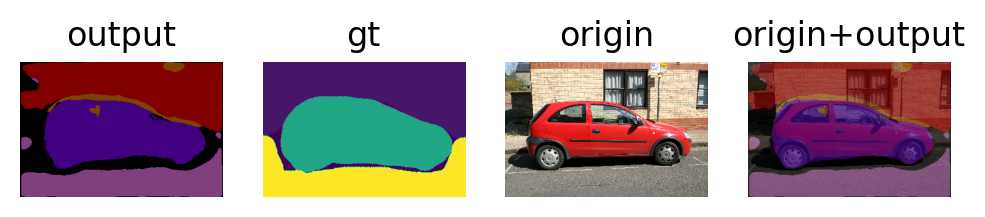

In [57]:
predict(net,'Dataset//msrc2_seg/images/','Dataset/msrc2_seg/gt_label/','7_8_s.bmp')